<a href="https://colab.research.google.com/github/msalmankhan03/Deep-Learning/blob/main/CNN/Transfer_Learning_on_Intel_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 94% 327M/346M [00:00<00:00, 518MB/s]
100% 346M/346M [00:00<00:00, 561MB/s]


In [3]:
!unzip -q intel-image-classification.zip -d /content/data


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobnet_preprocess
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
# Image size
IMG_SIZE = (150,150)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=None,  # will assign per model
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=None)  # will assign per model

# Load data (we'll set preprocessing_function later for each model)
def get_generators(preprocess_func):
    train_gen = train_datagen.flow_from_directory(
        "/content/data/seg_train/seg_train",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_gen = val_datagen.flow_from_directory(
        "/content/data/seg_test/seg_test",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    # Assign preprocessing function
    train_gen.preprocessing_function = preprocess_func
    val_gen.preprocessing_function = preprocess_func
    return train_gen, val_gen


Architecture 1: *****VGG16*****

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 130s 273ms/step - accuracy: 0.6578 - loss: 2.3134 - val_accuracy: 0.8597 - val_loss: 0.4086
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 242ms/step - accuracy: 0.7864 - loss: 0.5784 - val_accuracy: 0.8720 - val_loss: 0.3756
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - accuracy: 0.8125 - loss: 0.5004 - val_accuracy: 0.8763 - val_loss: 0.3870
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 242ms/step - accuracy: 0.8274 - loss: 0.4740 - val_accuracy: 0.8817 - val_loss: 0.3452
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 242ms/step - accuracy: 0.8334 - loss: 0.4551 - val_accuracy: 0.8837 - val_loss: 0.3434
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 109s 248ms/step - accuracy: 0.8354 - loss: 0.4529 - val_accuracy: 0.8907 - val_loss: 0.3341
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 107s 244ms/step - accuracy: 0.8390 - loss: 0.4334 - val_accuracy: 0.8913 - val_loss: 0.3263
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 107s 243ms/step - accuracy: 0.8387 -

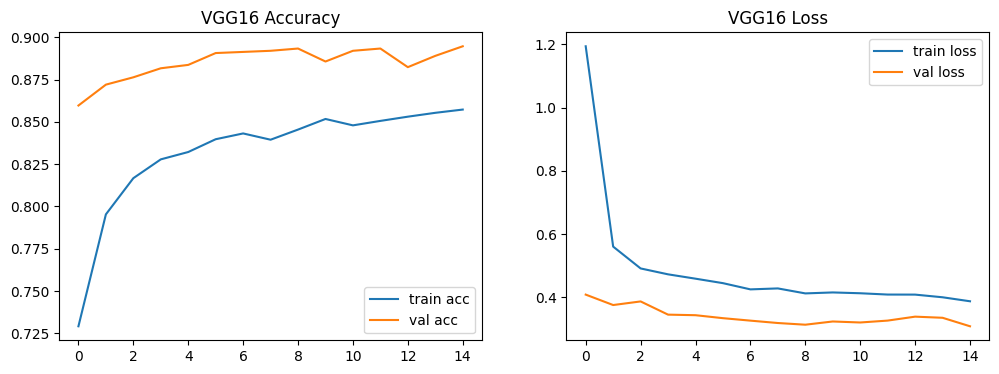

In [ ]:
train_gen, val_gen = get_generators(vgg_preprocess)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation='softmax')(x)  # 6 classes

model_vgg = Model(inputs=base_model.input, outputs=preds)
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg = model_vgg.fit(train_gen, validation_data=val_gen, epochs=15)

# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='train acc')
plt.plot(history_vgg.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('VGG16 Accuracy')

plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='train loss')
plt.plot(history_vgg.history['val_loss'], label='val loss')
plt.legend()
plt.title('VGG16 Loss')
plt.show()


Architecture 2: ***ResNet50***

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 123s 250ms/step - accuracy: 0.7511 - loss: 0.7515 - val_accuracy: 0.8887 - val_loss: 0.3073
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 221ms/step - accuracy: 0.8482 - loss: 0.4208 - val_accuracy: 0.8917 - val_loss: 0.2928
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 96s 219ms/step - accuracy: 0.8578 - loss: 0.3905 - val_accuracy: 0.9007 - val_loss: 0.2742
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.8643 - loss: 0.3685 - val_accuracy: 0.8957 - val_loss: 0.2824
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.8746 - loss: 0.3468 - val_accuracy: 0.9017 - val_loss: 0.2679
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 211ms/step - accuracy: 0.8848 - loss: 0.3329 - val_accuracy: 0.8927 - val_loss: 0.2973
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 211ms/step - accuracy: 0.8816 - loss: 0.3316 - val_accuracy: 0.9100 - val_loss: 0.2561
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 216ms/step - accuracy: 0.8846 - loss: 

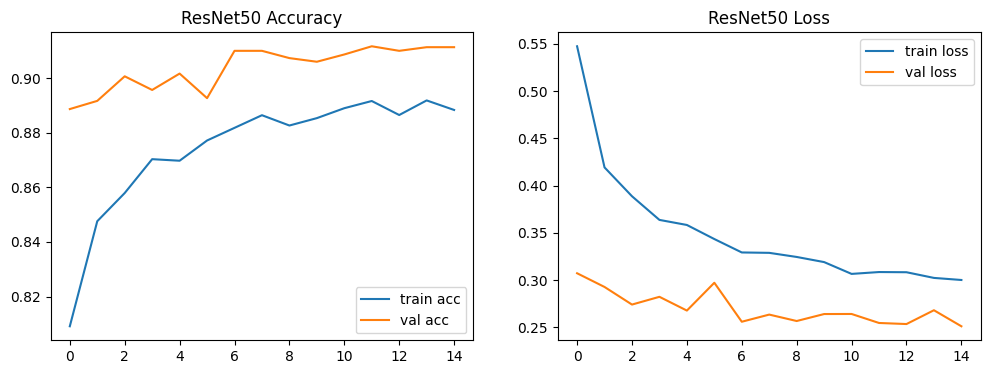

In [6]:
train_gen, val_gen = get_generators(resnet_preprocess)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=preds)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = model_resnet.fit(train_gen, validation_data=val_gen, epochs=15)

# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='train acc')
plt.plot(history_resnet.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('ResNet50 Accuracy')

plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='train loss')
plt.plot(history_resnet.history['val_loss'], label='val loss')
plt.legend()
plt.title('ResNet50 Loss')
plt.show()


Architecture 3: ***`EfficientNetB0`***

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.8132 - loss: 0.4989 - val_accuracy: 0.9150 - val_loss: 0.2280
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.8895 - loss: 0.2986 - val_accuracy: 0.9200 - val_loss: 0.2277
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.8984 - loss: 0.2650 - val_accuracy: 0.9210 - val_loss: 0.2225
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.9070 - loss: 0.2460 - val_accuracy: 0.9157 - val_loss: 0.2198
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.9083 - loss: 0.2461 - val_accuracy: 0.9210 - val_loss: 0.2152
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.9065 - loss: 0.2470 - val_accuracy: 0.9223 - val_loss: 0.2221
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.9128 - l

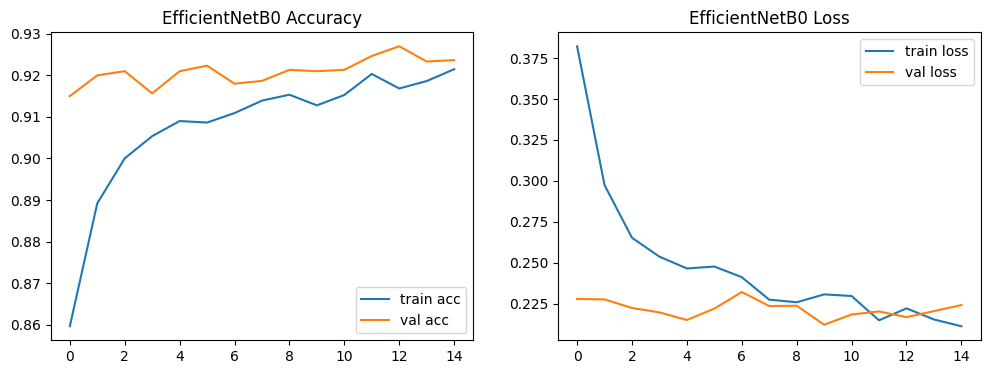

In [7]:
train_gen, val_gen = get_generators(effnet_preprocess)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=preds)
model_effnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_effnet = model_effnet.fit(train_gen, validation_data=val_gen, epochs=15)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_effnet.history['accuracy'], label='train acc')
plt.plot(history_effnet.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('EfficientNetB0 Accuracy')

plt.subplot(1,2,2)
plt.plot(history_effnet.history['loss'], label='train loss')
plt.plot(history_effnet.history['val_loss'], label='val loss')
plt.legend()
plt.title('EfficientNetB0 Loss')
plt.show()


Architecture 4: **MobileNetV2**

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


/tmp/ipython-input-1007928069.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 118s 237ms/step - accuracy: 0.5175 - loss: 1.2592 - val_accuracy: 0.6410 - val_loss: 0.9258
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 188ms/step - accuracy: 0.6399 - loss: 0.9350 - val_accuracy: 0.6510 - val_loss: 0.9148
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 190ms/step - accuracy: 0.6504 - loss: 0.9071 - val_accuracy: 0.6670 - val_loss: 0.8826
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.6638 - loss: 0.8788 - val_accuracy: 0.6767 - val_loss: 0.8274
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.6665 - loss: 0.8590 - val_accuracy: 0.6777 - val_loss: 0.8562
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 191ms/step - accuracy: 0.6823 - loss: 0.8363 - val_accuracy: 0.6487 - val_loss: 0.9247
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 191ms/step - accuracy: 0.6832 - loss: 0.8421 - val_accuracy: 0.6963 - val_loss: 0.8162
Epoch 8/15
439/439 ━━━━━━━━━━━━━━

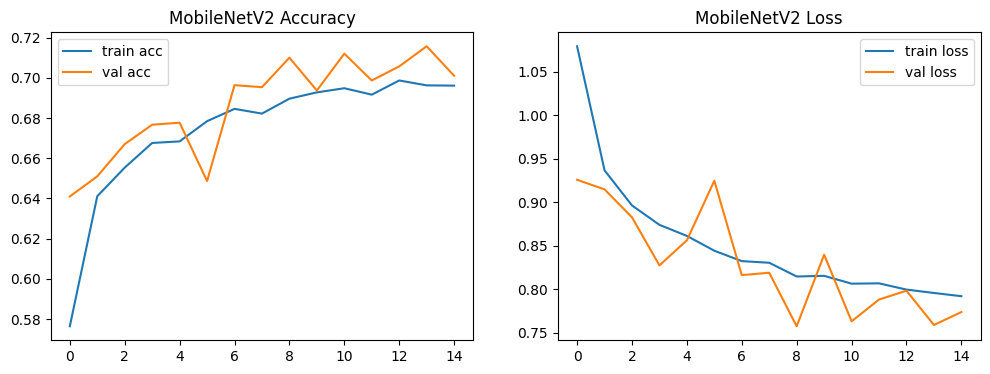

In [8]:
train_gen, val_gen = get_generators(mobnet_preprocess)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation='softmax')(x)

model_mobnet = Model(inputs=base_model.input, outputs=preds)
model_mobnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_mobnet = model_mobnet.fit(train_gen, validation_data=val_gen, epochs=15)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_mobnet.history['accuracy'], label='train acc')
plt.plot(history_mobnet.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('MobileNetV2 Accuracy')

plt.subplot(1,2,2)
plt.plot(history_mobnet.history['loss'], label='train loss')
plt.plot(history_mobnet.history['val_loss'], label='val loss')
plt.legend()
plt.title('MobileNetV2 Loss')
plt.show()
